In [16]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)


# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

# Apply preprocessing to each document in the dataset
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = CountVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vectorizing the text data...


In [17]:
import warnings
warnings.filterwarnings("ignore")
# Initialize centroids with KMeans
def initialize_centroids(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.cluster_centers_

# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia_and_labels(centroids, data, threshold=100000, distance_metric='euclidean'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia, labels

In [18]:
import numpy as np

class Particle:
    def __init__(self, data, n_clusters):
        self.position = np.random.rand(n_clusters, data.shape[1])  # Randomly initialize position
        self.velocity = np.zeros((n_clusters, data.shape[1]))  # Initialize velocity to zero
        self.best_position = np.copy(self.position)  # Initially, best position is the starting position
        self.best_fitness = float('inf')  # Initialize the best fitness to infinity
        self.fitness = float('inf')  # Current fitness of the particle

    def update_velocity(self, global_best_position, w=0.5, c1=0.5, c2=0.5):
        """Updates the particle's velocity based on its own experience and that of the swarm."""
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_component = c1 * r1 * (self.best_position - self.position)
        social_component = c2 * r2 * (global_best_position - self.position)
        inertia_component = w * self.velocity
        self.velocity = inertia_component + cognitive_component + social_component

    def update_position(self, bounds):
        """Updates the particle's position based on its velocity and applies bounding."""
        self.position += self.velocity
        # Ensure the new position does not exceed the data bounds
        self.position = np.clip(self.position, bounds[0], bounds[1])

    def evaluate_fitness(self, data):
        """Evaluates the fitness of the particle's current position using inertia (sum of squared distances)."""
        # Assuming `compute_inertia_and_labels` is a function that computes the inertia and assigns labels
        self.fitness, _ = compute_inertia_and_labels(self.position, data)
        # Update the best position and fitness if the current fitness is better
        if self.fitness < self.best_fitness:
            self.best_fitness = self.fitness
            self.best_position = np.copy(self.position)


In [19]:
def pso_gwo_kmeans(data, n_clusters, n_particles=10, max_iter=100):
    particles = [{'position': np.random.rand(n_clusters, data.shape[1]),
                  'velocity': np.zeros((n_clusters, data.shape[1])),
                  'best_position': None,
                  'fitness': float('inf')}
                 for _ in range(n_particles)]
    
    global_best = {'position': None, 'fitness': float('inf')}
    
    for iteration in range(max_iter):
        # Update fitness
        for particle in particles:
            centroids = particle['position']
            inertia, labels = compute_inertia_and_labels(centroids, data)  # Assume this function is defined elsewhere
            if inertia < particle['fitness']:
                particle['fitness'] = inertia
                particle['best_position'] = centroids
            if inertia < global_best['fitness']:
                global_best['fitness'] = inertia
                global_best['position'] = centroids
        
        # PSO update
        for particle in particles:
            update_velocity_and_position(particle, global_best['position'])
        
        # GWO update
        alpha, beta, delta = calculate_alpha_beta_delta(particles)
        A, C = 2 * a * np.random.rand() - a, 2 * np.random.rand()  # a decreases from 2 to 0 over iterations
        for particle in particles:
            update_wolf_position(particle, alpha, beta, delta, A)
        if iteration % kmeans_interval == 0:
            kmeans = KMeans(n_clusters=n_clusters, init=global_best['position'], n_init=1, random_state=42)
            kmeans.fit(data)
            global_best['position'] = kmeans.cluster_centers_
            global_best['fitness'], _ = compute_inertia_and_labels(global_best['position'], data)

    
    return global_best['position'], global_best['fitness']

In [20]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# def compute_inertia_and_labels(centroids, data):
#     distances = euclidean_distances(data, centroids)
#     labels = np.argmin(distances, axis=1)
#     inertia = np.sum((data - centroids[labels]) ** 2)
#     return inertia, labels

def initialize_with_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.cluster_centers_

# Update this function to match your data structure and constraints
def update_particle_position(particle, bounds):
    # Ensure particle's position stays within the bounds
    particle['position'] = np.clip(particle['position'], bounds[0], bounds[1])

# The complete hybrid PSO-GWO algorithm
def pso_gwo_kmeans(data, n_clusters, n_particles=10, max_iter=100, kmeans_interval=10):
    # Initialize particles with KMeans
    initial_centroids = initialize_with_kmeans(data, n_clusters)
    particles = [{'position': initial_centroids + np.random.rand(n_clusters, data.shape[1]) * 0.01,
                  'velocity': np.zeros((n_clusters, data.shape[1])),
                  'best_position': np.copy(initial_centroids),
                  'fitness': float('inf')}
                 for _ in range(n_particles)]
    
    global_best = {'position': np.copy(initial_centroids), 'fitness': float('inf')}
    
    for iteration in range(max_iter):
        # Update fitness
        for particle in particles:
            inertia, _ = compute_inertia_and_labels(particle['position'], data)
            if inertia < particle['fitness']:
                particle['fitness'] = inertia
                particle['best_position'] = np.copy(particle['position'])
            if inertia < global_best['fitness']:
                global_best['fitness'] = inertia
                global_best['position'] = np.copy(particle['position'])
        
        # PSO-GWO update logic goes here
        # This will include updating velocities and positions for PSO
        # And applying GWO update rules
        
        # KMeans refinement at specified intervals
        if iteration % kmeans_interval == 0 and iteration != 0:
            kmeans = KMeans(n_clusters=n_clusters, init=global_best['position'], n_init=1, random_state=42)
            kmeans.fit(data)
            global_best['position'] = kmeans.cluster_centers_
            global_best['fitness'], _ = compute_inertia_and_labels(global_best['position'], data)
    
    final_centroids = global_best['position']
    final_fitness = global_best['fitness']
    _, labels = compute_inertia_and_labels(final_centroids, data)
    return final_centroids, labels, final_fitness
n_clusters = 10 
best_centroids, labels, best_score = pso_gwo_kmeans(tfidf_matrix_reduced, n_clusters)

print("Best centroids:", best_centroids)
print("Labels:", labels)
print("Best score (Inertia):", best_score)
silhouette = silhouette_score(tfidf_matrix_reduced, labels)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Best centroids: [[ 3.43942642e-03  1.50379050e+00  2.96075717e-02 -1.12248957e+00
  -9.38464850e-02 -1.74958706e-01 -1.21344239e-01 -5.52517511e-02
   1.49070576e-01 -8.54774565e-02  1.49550484e-02  4.67030033e-02
   2.19655767e-01  6.84074983e-02 -1.35125637e-01 -2.28353310e-02
  -2.93378327e-02  3.94080952e-02 -1.37099728e-01 -3.93198095e-02
   3.64273004e-02  1.73649222e-01  9.17833373e-02  5.31863347e-02
   1.00386217e-02  1.26385570e-01  1.02536134e-01 -2.58920133e-01
  -3.33854184e-02 -4.39050309e-02  4.67620939e-02 -6.69939145e-02
  -2.97787637e-02 -1.23561837e-01 -8.15871358e-03 -3.47067639e-02
  -6.02869596e-03 -4.99165729e-02  5.70389330e-02 -6.55035749e-02
  -3.27969901e-02  1.92551967e-02 -5.46533428e-02  6.12720326e-02
   9.03876591e-03  6.54286444e-02  4.93442044e-02  1.37234211e-01
  -1.23455049e-02 -9.50757321e-03 -1.17467709e-01 -8.44008178e-02
   9.56698731e-02  1.53143574e-02  7.02386647e-02 -5.75474501e-02
  -8.47490206e-02  9.16014910e-02  5.73775060e-02 -1.1081158

Silhouette Score: 0.9728775024414062
Davies-Bouldin Index: 0.48501800036288323
Calinski-Harabasz Index: 147729.37857798126


In [21]:
from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    best_centroids, labels, best_score = pso_gwo_kmeans(tfidf_matrix_reduced, n_clusters)
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, labels)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

    # Store metrics
    silhouette_scores.append(silhouette)
    print(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

0.99854606
0.9977619
0.9975094
0.997042
0.99703217
0.9970229
0.97411793
0.9726195
0.9728775
0.9702548
0.9712209
0.97143906
0.97050893
0.96990824
0.9705858
0.9580561
0.9608772
0.9587323
0.95868754


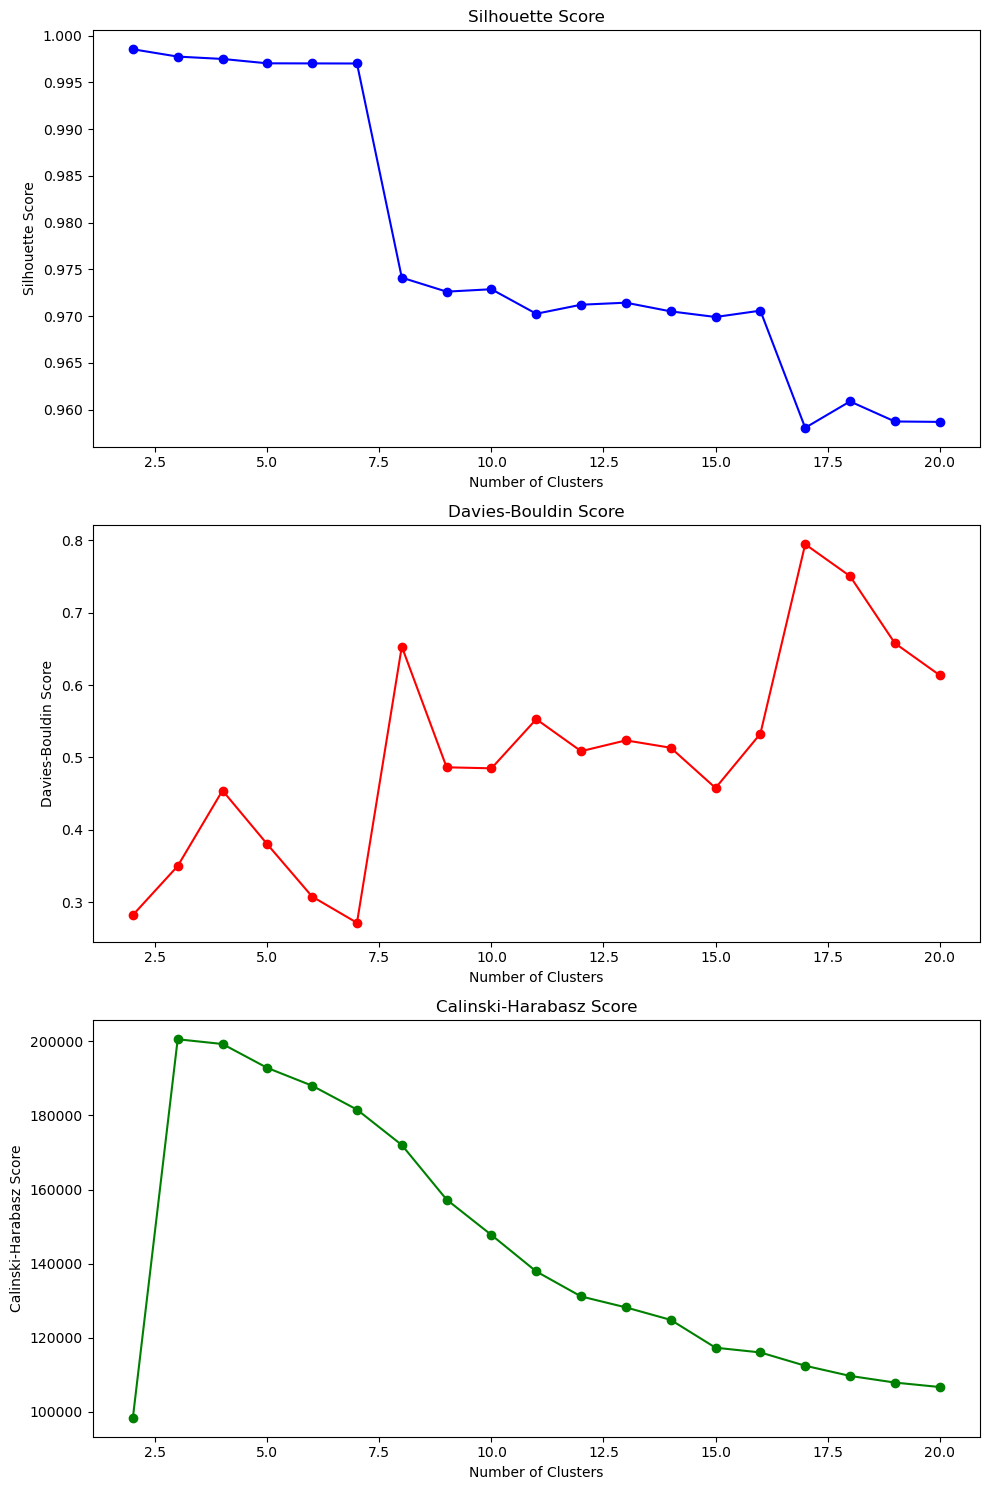

In [12]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_count-GWO-PSO_Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count-GWO-PSO_Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count-GWO-PSO_Kmeans.png")
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.998546,0.282495,98424.378550
3,0.997762,0.350075,200523.053915
4,0.997509,0.454357,199240.366308
5,0.997042,0.380142,192792.371576
6,0.997032,0.307926,187995.655287
7,0.997023,0.271771,181546.776152
8,0.974118,0.653094,172002.964409
9,0.972619,0.486402,157276.459948
10,0.972878,0.485018,147729.378578
11,0.970255,0.552836,137894.011483


In [15]:
df.to_csv('Count_GWO+PSO+Firefly_Scores.csv')